<a href="https://colab.research.google.com/github/Mustafa-Caliskan/Insect-Detection-System-YOLOv8-ViT-Gemini/blob/main/notebooks/2_Insects_Detection_Augmented_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# 🚀 FİNAL PİPELİNE: YOLOv8 + ViT + Gemini LLM (Tarımsal Rapor)
# =============================================================================

print("📦 Gerekli kütüphaneler kuruluyor...")
%pip install -q ultralytics transformers torch pillow opencv-python matplotlib google-genai

import os
import shutil
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from ultralytics import YOLO
from transformers import ViTImageProcessor, ViTForImageClassification
from google.colab import drive, files
from pathlib import Path
import time
from google import genai

print("✅ Kütüphaneler yüklendi!")

📦 Gerekli kütüphaneler kuruluyor...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Kütüphaneler yüklendi!


In [4]:
# =============================================================================
# 1. DRIVE BAĞLANTISI VE YOLLAR
# =============================================================================
# =============================================================================
# DRIVE VE MODEL YOLLARI (MUTLAKA ÖNCE ÇALIŞTIR)
# =============================================================================

from google.colab import drive
import os

print("\n🔌 Drive bağlanıyor...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Kendi Google Drive dizininize göre bu yolu güncelleyin
DRIVE_BASE = "/content/drive/MyDrive/bocek_proje2"

# MODEL KLASÖRÜ (AUGMENTED)
MODEL_PATH = f"{DRIVE_BASE}/yeni_proje/proje_model/agumenteli"

# MODEL DOSYALARI
YOLO_FILE = f"{DRIVE_BASE}/yeni_proje/proje_model/best.pt"
VIT_ZIP_FILE = f"{MODEL_PATH}/VIT_BOCEK_AUG_FINAL.zip"

print("✅ Yollar tanımlandı!")

print("\n🔌 Drive bağlanıyor...")
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DRIVE_BASE = "/content/drive/MyDrive/bocek_proje2"
MODEL_PATH = f"{DRIVE_BASE}/yeni_proje/proje_model"

# Model dosyaları
MODEL_PATH = f"{DRIVE_BASE}/yeni_proje/proje_model/agumenteli"
VIT_ZIP_FILE = f"{MODEL_PATH}/VIT_BOCEK_AUG_FINAL.zip"
VIT_EXTRACT_DIR = "/content/temp_vit_aug"

print("\n📂 Dosya Kontrolleri:")
print(f"   • YOLO: {YOLO_FILE} → {'✅' if os.path.exists(YOLO_FILE) else '❌'}")
print(f"   • ViT ZIP: {VIT_ZIP_FILE} → {'✅' if os.path.exists(VIT_ZIP_FILE) else '❌'}")

if not all([os.path.exists(YOLO_FILE), os.path.exists(VIT_ZIP_FILE)]):
    raise FileNotFoundError("Model dosyaları eksik!")


🔌 Drive bağlanıyor...
✅ Yollar tanımlandı!

🔌 Drive bağlanıyor...

📂 Dosya Kontrolleri:
   • YOLO: /content/drive/MyDrive/bocek_proje2/yeni_proje/proje_model/best.pt → ✅
   • ViT ZIP: /content/drive/MyDrive/bocek_proje2/yeni_proje/proje_model/agumenteli/VIT_BOCEK_AUG_FINAL.zip → ✅


In [5]:
# =============================================================================
# 2. ViT MODEL AÇMA VE HAZIRLIK
# =============================================================================

VIT_EXTRACT_DIR = "/content/temp_vit"

print("\n📦 ViT modeli hazırlanıyor...")
if not os.path.exists(VIT_EXTRACT_DIR):
    shutil.unpack_archive(VIT_ZIP_FILE, VIT_EXTRACT_DIR)
    print("   ✅ Zip açıldı!")

# Model klasörünü bul
final_vit_path = None
for root, dirs, files_list in os.walk(VIT_EXTRACT_DIR):
    has_weights = "pytorch_model.bin" in files_list or "model.safetensors" in files_list
    if "config.json" in files_list and has_weights:
        final_vit_path = root
        break

if not final_vit_path:
    raise FileNotFoundError("ViT model yapısı hatalı!")

print(f"   ✅ ViT klasörü: {final_vit_path}")



📦 ViT modeli hazırlanıyor...
   ✅ Zip açıldı!
   ✅ ViT klasörü: /content/temp_vit


In [6]:
# =============================================================================
# 3. MODELLERİ YÜKLE (YOLO + ViT + Gemini)
# =============================================================================

print("\n🤖 Modeller yükleniyor...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   • Device: {device}")

# YOLO
yolo_model = YOLO(YOLO_FILE)
print("   ✅ YOLO hazır!")

# ViT Processor
if "preprocessor_config.json" in os.listdir(final_vit_path):
    vit_processor = ViTImageProcessor.from_pretrained(final_vit_path)
else:
    vit_processor = ViTImageProcessor.from_pretrained(
        "google/vit-base-patch16-224-in21k"
    )

# ViT Model
vit_model = ViTForImageClassification.from_pretrained(final_vit_path).to(device)
vit_model.eval()

print(f"✅ Augmented ViT yüklendi | Sınıf sayısı: {len(vit_model.config.id2label)}")

# Gemini LLM
print("\n🧠 Gemini LLM bağlanıyor...")
GEMINI_API_KEY = "YOUR_GEMINI_API_KEY_HERE" # Buraya kendi API anahtarınızı girin

try:
    client = genai.Client(api_key=GEMINI_API_KEY)
    # Test et
    test_response = client.models.generate_content(
        model="gemini-2.0-flash-exp",
        contents="Merhaba, çalışıyor musun?"
    )
    print("   ✅ Gemini bağlantısı başarılı!")
except Exception as e:
    print(f"   ⚠️ Gemini bağlantı hatası: {e}")
    print("   → API Key'i kontrol et!")
    client = None



🤖 Modeller yükleniyor...
   • Device: cuda
   ✅ YOLO hazır!


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

✅ Augmented ViT yüklendi | Sınıf sayısı: 21

🧠 Gemini LLM bağlanıyor...
   ✅ Gemini bağlantısı başarılı!


In [7]:
# =============================================================================
# 4. BÖCEK KATEGORİLERİ (Senin 20 Sınıfına Göre Düzenlendi)
# =============================================================================

INSECT_DATABASE = {
    # ✅ FAYDALI BÖCEKLER (Korunması gerekenler)
    "bees": {"category": "Faydalı", "detail": "Tozlaşma sağlayan, ekosistem ve ürün verimi için hayati dost böcek."},
    "ladybug": {"category": "Faydalı", "detail": "Yaprak bitlerini yiyerek biyolojik mücadele sağlayan doğal avcı."},
    "green_lacewing": {"category": "Faydalı", "detail": "Birçok zararlı böceğin yumurta ve larvasını yiyen etkili predatör."},
    "butterfly": {"category": "Faydalı", "detail": "Tozlaşmaya katkı sağlayan ve biyoçeşitlilik göstergesi olan zararsız canlı."},
    "dragonfly": {"category": "Faydalı", "detail": "Uçan zararlı böcekleri ve sivrisinekleri avlayan başarılı avcı."},
    "mantis": {"category": "Faydalı", "detail": "Pusuda bekleyerek birçok zararlı böceği tüketen genel avcı böcek."},

    # ⚠️ ZARARLI BÖCEKLER (Mücadele gerekenler)
    "aphid": {"category": "Zararlı", "detail": "Bitki özsuyunu emerek bitkiyi zayıflatan ve virüs hastalıkları taşıyan zararlı."},
    "caterpillar": {"category": "Zararlı", "detail": "Bitki yapraklarını hızla yiyerek bitki gelişimini durduran larva aşaması."},
    "cicada": {"category": "Zararlı", "detail": "Bitki gövdelerine yumurta bırakarak ve özsu emerek bitkiye zarar veren canlı."},
    "grasshopper": {"category": "Zararlı", "detail": "Yeşil aksamı hızla tüketerek geniş alanlarda büyük ekonomik kayıp yaratan zararlı."},
    "leafhopper": {"category": "Zararlı", "detail": "Yaprakların altından özsu emerek yapraklarda sararma ve kurumaya neden olur."},
    "mole_cricket": {"category": "Zararlı", "detail": "Toprak altında köklere zarar veren, bitkiyi kökten kurutan tehlikeli zararlı."},
    "planthopper": {"category": "Zararlı", "detail": "Bitki besin iletimini engelleyen ve isli küf oluşumuna neden olan özsu emici."},
    "rice_bug": {"category": "Zararlı", "detail": "Özellikle çeltik ve tahıllarda süt olum döneminde taneleri emerek boşaltan zararlı."},
    "stem_borer": {"category": "Zararlı", "detail": "Gövde içine girerek bitkinin iletim demetlerini kesen ve kurumasına yol açan kurt."},
    "stink_bug": {"category": "Zararlı", "detail": "Meyve ve sebzeleri emerek şekil bozukluğuna ve pazar değeri kaybına yol açan zararlı."},
    "weevil": {"category": "Zararlı", "detail": "Tohumlara, meyvelere ve köklere zarar veren hortumlu böcek türü."},

    # 🟠 NÖTR BÖCEKLER (Doğal dengenin parçası)
    "ant": {"category": "Nötr", "detail": "Toprağı havalandırır ancak bazen yaprak bitlerini koruyarak dolaylı sorun çıkarabilir."},
    "spider": {"category": "Nötr", "detail": "Genel ekosistemde avcı rolündedir; doğrudan bitki zararlısı değildir."},
    "rhino_beetle": {"category": "Nötr", "detail": "Genellikle çürüyen maddelerle beslenen, bitkiye doğrudan zararı olmayan büyük böcek."}
}

def get_insect_info(species_name):
    """Böcek türüne göre kategori ve detay döndürür"""
    # ViT modelinden gelen etiketi (lowercase) veritabanında ara
    species_name_clean = species_name.lower().replace(" ", "_")

    if species_name_clean in INSECT_DATABASE:
        return INSECT_DATABASE[species_name_clean]

    # Eğer birebir eşleşme yoksa (içinde geçiyorsa)
    for key in INSECT_DATABASE:
        if key in species_name_clean:
            return INSECT_DATABASE[key]

    return {"category": "Bilinmeyen", "detail": "Bu tür hakkında spesifik tarımsal veri bulunamadı."}

In [8]:
# =============================================================================
# 5. GEMİNİ İLE TARIMSAL RAPOR OLUŞTUR
# =============================================================================

def generate_agricultural_report(detections, image_name="test_image"):
    """
    Tespit edilen böceklere göre Gemini ile tarımsal rapor oluşturur

    Args:
        detections: [{species, category, confidence, detail}, ...]
        image_name: Görsel adı
    """

    if not client:
        print("⚠️ Gemini bağlantısı yok, rapor oluşturulamadı!")
        return None

    # İstatistikleri hesapla
    total = len(detections)
    categories = {"Faydalı": 0, "Zararlı": 0, "Nötr": 0, "Bilinmeyen": 0}
    species_list = []

    for det in detections:
        categories[det['category']] += 1
        species_list.append(f"{det['species']} ({det['category']}, %{det['confidence']:.0f} güven)")

    # Prompt oluştur (Tarımsal odaklı)
    prompt = f"""
Sen bir tarım danışmanı yapay zekasısın. Aşağıdaki böcek tespit sonuçlarına göre çiftçiye profesyonel bir rapor hazırla:

📊 TESPİT İSTATİSTİKLERİ:
- Toplam tespit: {total} adet
- Faydalı böcek: {categories['Faydalı']} adet
- Zararlı böcek: {categories['Zararlı']} adet
- Nötr böcek: {categories['Nötr']} adet

🐛 TESPİT EDİLEN TÜRLER:
{chr(10).join(f"• {s}" for s in species_list)}

📋 DETAYLI BİLGİLER:
{chr(10).join(f"• {d['species']}: {d['detail']}" for d in detections)}

Lütfen aşağıdaki formatta bir rapor hazırla:

🎯 DURUM ÖZETİ:
[Genel durumu 2-3 cümleyle özetle]

⚠️ UYARILAR VE TAVSİYELER:
[Zararlı böcekler varsa acil önlemler, faydalı böcekler varsa koruma önerileri]

✅ ÖNERİLEN AKSIYONLAR:
[Somut, uygulanabilir adımlar - madde madde]

🌱 GENEL DEĞERLENDİRME:
[Tarlanın/bahçenin genel sağlık durumu]

NOT: Raporu Türkçe, anlaşılır ve çiftçi dostu bir dille yaz. Teknik terimler kullanıyorsan parantez içinde açıkla.
"""

    print("\n🧠 Gemini rapor oluşturuyor...")

    try:
        response = client.models.generate_content(
            model="gemini-2.0-flash-exp",
            contents=prompt
        )

        report = response.text
        print("   ✅ Rapor hazır!")
        return report

    except Exception as e:
        print(f"   ❌ Gemini hatası: {e}")
        return None


In [9]:
# =============================================================================
# 6. GÖRSEL DASHBOARD FONKSİYONU
# =============================================================================

def draw_admin_dashboard(metrics):
    """Profesyonel teknik analiz dashboard'u"""
    bg_color, card_color, text_color = '#0f172a', '#1e293b', '#f8fafc'
    accent_color, secondary_accent = '#10b981', '#3b82f6'

    fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.axis('off')

    ax.text(50, 92, "🤖 TARIMSAL BÖCEK ANALİZ PANELİ",
            color=text_color, fontsize=20, fontweight='bold', ha='center')
    ax.text(50, 86, "YOLOv8 + ViT + Gemini LLM Hybrid System",
            color=secondary_accent, fontsize=11, ha='center', alpha=0.8)

    def draw_card(x, y, w, h_c, title, value, unit="", icon=""):
        rect = patches.FancyBboxPatch((x, y), w, h_c, boxstyle="round,pad=1",
                                      facecolor=card_color, edgecolor=secondary_accent, linewidth=0.5)
        ax.add_patch(rect)
        ax.text(x + w*0.5, y + h_c*0.75, f"{icon} {title}",
                color=text_color, fontsize=9, ha='center', alpha=0.7)
        ax.text(x + w*0.5, y + h_c*0.35, f"{value}{unit}",
                color=accent_color, fontsize=22, fontweight='bold', ha='center')

    draw_card(5, 50, 28, 23, "TESPİT", metrics['total'], " Adet", "🔍")
    draw_card(36, 50, 28, 23, "FAYDALII", metrics['beneficial'], " Adet", "✅")
    draw_card(67, 50, 28, 23, "ZARARLI", metrics['harmful'], " Adet", "⚠️")

    draw_card(5, 20, 28, 20, "GÜVENİ", f"{metrics['confidence']:.1f}", "%", "🎯")
    draw_card(36, 20, 28, 20, "HIZ", f"{metrics['speed']:.2f}", " sn", "⚡")
    draw_card(67, 20, 28, 20, "LLM", "Gemini", " 2.0", "🧠")

    ax.text(50, 5, "Pipeline: YOLO Detection → ViT Classification → Gemini Report",
            color=text_color, fontsize=8, ha='center', alpha=0.5)

    plt.tight_layout()
    plt.show()


In [16]:
# =============================================================================
# 7. ANA ANALİZ FONKSİYONU (YOLO + ViT + Gemini)
# =============================================================================

def analyze_image_complete(image_path, conf_threshold=0.25):
    """
    Tam entegre analiz: YOLO → ViT → Gemini Rapor
    """
    start_time = time.time()

    print(f"\n{'='*70}")
    print(f"📸 ANALİZ: {os.path.basename(image_path)}")
    print(f"{'='*70}")

        # Resmi oku
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Resim okunamadı!")
        return

    original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = original_rgb.shape

    # YOLO tespiti
    print("\n🔍 YOLO tespiti...")
    results = yolo_model.predict(
        original_rgb,
        conf=conf_threshold,
        imgsz=1024,
        verbose=False
    )[0]

    if results.boxes is None:
        print("❌ YOLO hiç box üretmedi")
        boxes = []
    else:
        boxes = results.boxes.xyxy.cpu().numpy()
        print(f"🔎 YOLO ham box sayısı: {len(results.boxes)}")

    print(f"   ✅ {len(boxes)} böcek tespit edildi!")

    if len(boxes) == 0:
        print("\n⚠️ Hiçbir böcek bulunamadı!")
        return

    # ViT sınıflandırması
    print("\n🐛 ViT sınıflandırma...")

    detections = []
    display_img = original_rgb.copy()

    for idx, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        crop = original_rgb[y1:y2, x1:x2]
        if crop.size == 0 or crop.shape[0] < 10:
            continue

        try:
            inputs = vit_processor(images=Image.fromarray(crop), return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = vit_model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                conf, pred_idx = torch.max(probs, 1)

            species = vit_model.config.id2label[pred_idx.item()]
            score = conf.item()

            # Veritabanından bilgi al
            insect_info = get_insect_info(species)

            detections.append({
                'species': species,
                'category': insect_info['category'],
                'detail': insect_info['detail'],
                'confidence': score * 100,
                'bbox': (x1, y1, x2, y2)
            })

            # Kategori bazlı renk
            colors = {
                "Faydalı": (0, 255, 0),      # Yeşil
                "Zararlı": (255, 0, 0),      # Kırmızı
                "Nötr": (255, 165, 0),       # Turuncu
                "Bilinmeyen": (128, 128, 128) # Gri
            }
            color = colors.get(insect_info['category'], (255, 255, 255))

            # Çizim
            cv2.rectangle(display_img, (x1, y1), (x2, y2), color, 3)
            text = f"{species} ({insect_info['category'][:3]})"
            cv2.putText(display_img, text, (x1, y1-5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            print(f"   • {species} → {insect_info['category']} (%{score*100:.0f})")

        except Exception as e:
            print(f"   ❌ Tespit #{idx+1} hatası: {e}")
            continue

    # Sonuç görseli
    print(f"\n{'='*70}")
    print(f"✅ {len(detections)} böcek sınıflandırıldı!")
    print(f"{'='*70}")

    plt.figure(figsize=(12, 8))
    plt.imshow(display_img)
    plt.title(f"Tespit Sonuçları | {len(detections)} Böcek", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

     # Dashboard metrikleri
    categories_count = {"Faydalı": 0, "Zararlı": 0, "Nötr": 0}
    for det in detections:
        if det['category'] in categories_count:
            categories_count[det['category']] += 1

    metrics = {
        'total': len(detections),
        'beneficial': categories_count['Faydalı'],
        'harmful': categories_count['Zararlı'],
        'confidence': np.mean([d['confidence'] for d in detections]),
        'speed': time.time() - start_time,
        'dataset': "Augmented (≈45K images)"
    }

    draw_admin_dashboard(metrics)

    # Gemini LLM Raporu
    if client and detections:
        print("\n" + "="*70)
        print("📝 TARIMSAL RAPOR (Gemini LLM)")
        print("="*70 + "\n")

        report = generate_agricultural_report(detections, os.path.basename(image_path))

        if report:
            print(report)
            print("\n" + "="*70)
        else:
            print("⚠️ Rapor oluşturulamadı!")

    return detections


📤 CANLI TEST - Böcek Resmi Yükle
Bilgisayarından bir tarla/bahçe fotoğrafı seç...



Saving tırtıl.jpeg to tırtıl.jpeg

📁 Dosya: tırtıl.jpeg

📸 ANALİZ: tırtıl.jpeg

🔍 YOLO tespiti...
🔎 YOLO ham box sayısı: 1
   ✅ 1 böcek tespit edildi!

🐛 ViT sınıflandırma...
   • caterpillar → Zararlı (%100)

✅ 1 böcek sınıflandırıldı!


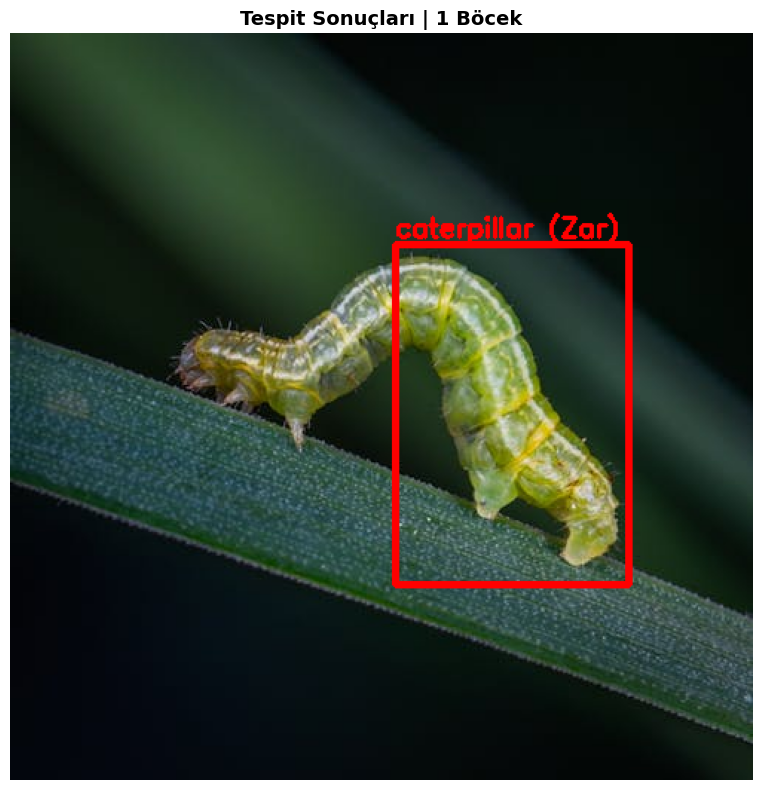

/tmp/ipython-input-3735465804.py:42: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3735465804.py:42: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3735465804.py:42: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3735465804.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3735465804.py:42: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-PO

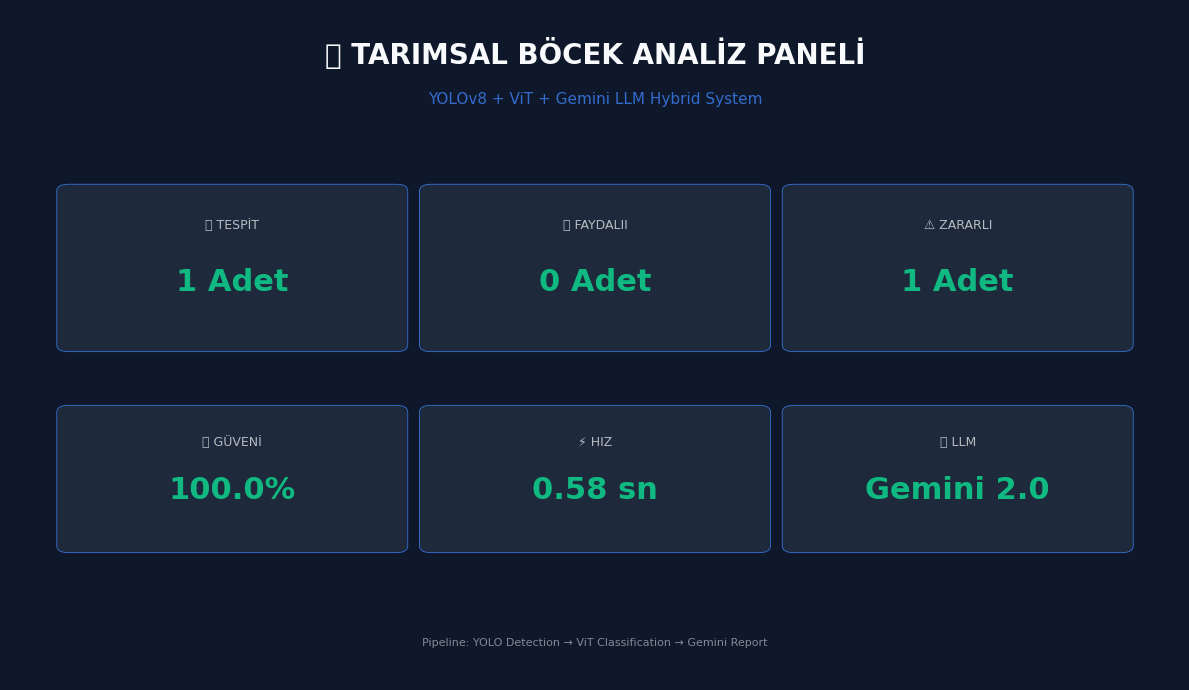


📝 TARIMSAL RAPOR (Gemini LLM)


🧠 Gemini rapor oluşturuyor...
   ✅ Rapor hazır!
**TARIM ARAZİSİ BÖCEK TESPİT RAPORU**

**Tarih:** [Raporun düzenlendiği tarih]

**Arazi:** [Arazi sahibinin adı veya arazi konumu]

🎯 **DURUM ÖZETİ:**

Arazinizde yapılan incelemeler sonucunda, bitki gelişimini olumsuz etkileyebilecek zararlı bir böcek türü olan tırtıl (caterpillar) tespit edilmiştir. Bu durum, özellikle genç bitkiler için risk oluşturabilir ve verimde kayıplara neden olabilir. Hızlı ve doğru müdahale ile bu sorunun önüne geçilebilir.

⚠️ **UYARILAR VE TAVSİYELER:**

Tırtıllar, bitkilerin yapraklarını yiyerek fotosentezi (bitkilerin güneş ışığıyla besin üretme süreci) engeller ve bitki gelişimini durdurur. Özellikle genç bitkilerde bu durum daha ciddi sonuçlar doğurabilir. Bu nedenle, tırtıl popülasyonunu kontrol altına almak ve bitkileri korumak için acil önlemler alınması gerekmektedir.

✅ **ÖNERİLEN AKSIYONLAR:**

1.  **Elle Toplama:** Küçük alanlarda veya az sayıda tırtıl görüldüğünde,

In [18]:
# =============================================================================
# 8. CANLI TEST - DOSYA YÜKLEME
# =============================================================================

print("\n" + "="*70)
print("📤 CANLI TEST - Böcek Resmi Yükle")
print("="*70)
print("Bilgisayarından bir tarla/bahçe fotoğrafı seç...")
print("="*70 + "\n")

uploaded = files.upload()

if uploaded:
    for filename in uploaded.keys():
        print(f"\n{'='*70}")
        print(f"📁 Dosya: {filename}")
        print(f"{'='*70}")

        try:
            with open(filename, 'wb') as f:
                f.write(uploaded[filename])

            analyze_image_complete(filename, conf_threshold=0.25)

        except Exception as e:
            print(f"❌ HATA: {e}")
            import traceback
            traceback.print_exc()
else:
    print("⚠️ Hiçbir dosya yüklenmedi!")

print("\n" + "="*70)
print("✅ ANALİZ TAMAMLANDI!")
print("="*70)